# DEMAND ANALYST

Data Upload and Install Package

In [76]:
!pip install openpyxl
import pandas as pd # Import the pandas library and assign it to the alias 'pd'
df = pd.read_excel('/content/drive/MyDrive/Demand Planning Analyst/Worksheet in (Share) Technical Test – Demand Planner.xlsx', engine='openpyxl')

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

DATA INSPECTION

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37297 entries, 0 to 37296
Data columns (total 49 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   KODE_SUBDIST         37297 non-null  int64  
 1   BRANCH_SUBD          37297 non-null  object 
 2   Nama_Branch_EPM      37297 non-null  object 
 3   RSPH                 37297 non-null  object 
 4   Type_Sub             37297 non-null  object 
 5   Line of Business     37297 non-null  object 
 6   ProductID            37297 non-null  object 
 7   Umbrand              37297 non-null  object 
 8   Brand                37297 non-null  object 
 9   DocumentID           37297 non-null  object 
 10  Price                37297 non-null  float64
 11  2022-01-01 00:00:00  37297 non-null  int64  
 12  2022-02-01 00:00:00  37297 non-null  int64  
 13  2022-03-01 00:00:00  37297 non-null  int64  
 14  2022-04-01 00:00:00  37297 non-null  int64  
 15  2022-05-01 00:00:00  37297 non-null 

Terdapat 37297 data dan tidak ada data yg kosong atau null

Data Preparation and Processing

In [79]:
# Salin DataFrame agar tidak mengubah yang asli
df_head = df.copy()

# Konversi header (nama kolom) tanpa mengubah isi data
df_head.columns = [
    pd.to_datetime(col, format='%m/%d/%Y', errors='coerce').strftime('%B %Y') if i in range(11, 49) else col
    for i, col in enumerate(df.columns)
]

print(df_head.head())  # Cetak hasil untuk memastikan perubahan

   KODE_SUBDIST BRANCH_SUBD Nama_Branch_EPM           RSPH Type_Sub  \
0        111111         KND             BAC  RM I SumBagUt      KND   
1        111111         KND             BAC  RM I SumBagUt      KND   
2        111111         KND             BAC  RM I SumBagUt      KND   
3        111111         KND             BAC  RM I SumBagUt      KND   
4        111111         KND             BAC  RM I SumBagUt      KND   

  Line of Business ProductID     Umbrand       Brand DocumentID  ...  \
0             KN 3     DBC01  DIABETASOL    DIACARE      FAKTUR  ...   
1             KN 3     DBC02  DIABETASOL    DIACARE      FAKTUR  ...   
2             KN 3     DBC03  DIABETASOL    DIACARE      FAKTUR  ...   
3             KN 3     DBC04  DIABETASOL    DIACARE      FAKTUR  ...   
4             KN 3     DBJCO  DIABETASOL  DIABETASOL      RETUR  ...   

   May 2024  June 2024  July 2024  August 2024  September 2024  October 2024  \
0         0          0          0            0              

In [80]:
df.columns = [
    pd.to_datetime(col, format='%m/%d/%Y', errors='coerce').strftime('%B %Y') if i in range(11, 49) else col
    for i, col in enumerate(df.columns)
]

Agar memudahkan proses analisis dibuat kolom baru "Bulan" dan "Qty" untuk nantinya dapat memudahkan proses pemodelan


In [81]:

# Daftar kolom yang tidak diubah (identifier)
id_vars = ['KODE_SUBDIST', 'BRANCH_SUBD', 'Nama_Branch_EPM', 'RSPH', 'Type_Sub',
           'Line of Business', 'ProductID', 'Umbrand', 'Brand', 'DocumentID', 'Price']

# Daftar kolom bulan yang akan diubah menjadi satu kolom
value_vars = df.columns[11:49]  # Kolom 12-49 adalah data bulanan

# Konversi format wide ke long
df_long = df.melt(id_vars=id_vars, value_vars=value_vars, var_name='Bulan', value_name='qty')

# Menampilkan hasil
print(df_long.head())

   KODE_SUBDIST BRANCH_SUBD Nama_Branch_EPM           RSPH Type_Sub  \
0        111111         KND             BAC  RM I SumBagUt      KND   
1        111111         KND             BAC  RM I SumBagUt      KND   
2        111111         KND             BAC  RM I SumBagUt      KND   
3        111111         KND             BAC  RM I SumBagUt      KND   
4        111111         KND             BAC  RM I SumBagUt      KND   

  Line of Business ProductID     Umbrand       Brand DocumentID    Price  \
0             KN 3     DBC01  DIABETASOL    DIACARE      FAKTUR  13.4825   
1             KN 3     DBC02  DIABETASOL    DIACARE      FAKTUR  34.0155   
2             KN 3     DBC03  DIABETASOL    DIACARE      FAKTUR  13.4825   
3             KN 3     DBC04  DIABETASOL    DIACARE      FAKTUR  34.0155   
4             KN 3     DBJCO  DIABETASOL  DIABETASOL      RETUR  99.4065   

          Bulan  qty  
0  January 2022    0  
1  January 2022    0  
2  January 2022    0  
3  January 2022    0  
4

In [82]:
df = df_long

In [83]:
df['qty'] = df['qty'].astype(int)

# Cek tipe data setelah perubahan
print(df.dtypes)

KODE_SUBDIST          int64
BRANCH_SUBD          object
Nama_Branch_EPM      object
RSPH                 object
Type_Sub             object
Line of Business     object
ProductID            object
Umbrand              object
Brand                object
DocumentID           object
Price               float64
Bulan                object
qty                   int64
dtype: object


In [84]:
# Hitung standar deviasi dan koefisien variasi untuk melihat ketidakstabilan
df_stats = df.groupby("Nama_Branch_EPM")["qty"].agg(["mean", "std"])
df_stats["Coef_Variation"] = df_stats["std"] / df_stats["mean"]  # Koefisien Variasi (CV)

print(df_stats)

                         mean            std  Coef_Variation
Nama_Branch_EPM                                             
BAC                145.221818     615.713182        4.239812
BD2               1339.489609   12849.844629        9.593090
BDG               2375.234798   22787.890959        9.593953
BDL               1109.501785    5658.987490        5.100476
BGR                774.557421   12226.954192       15.785730
BKL                248.005296    1473.642004        5.941978
BKS               1260.998977   18984.490841       15.055120
BMS                682.659348    5575.051789        8.166667
BPP                442.155130    5024.329367       11.363273
BTM                611.392789    4766.642310        7.796367
CRB               1045.892031    8081.436416        7.726836
DPK                984.053644    8694.601854        8.835496
DPS               1864.676533   14289.773992        7.663406
JBI                343.131469    1935.831378        5.641661
JBR                369.8

Data Analisis rendahnya akurasi tingkat cabang dengan menganalisis tingkat fluktuasi

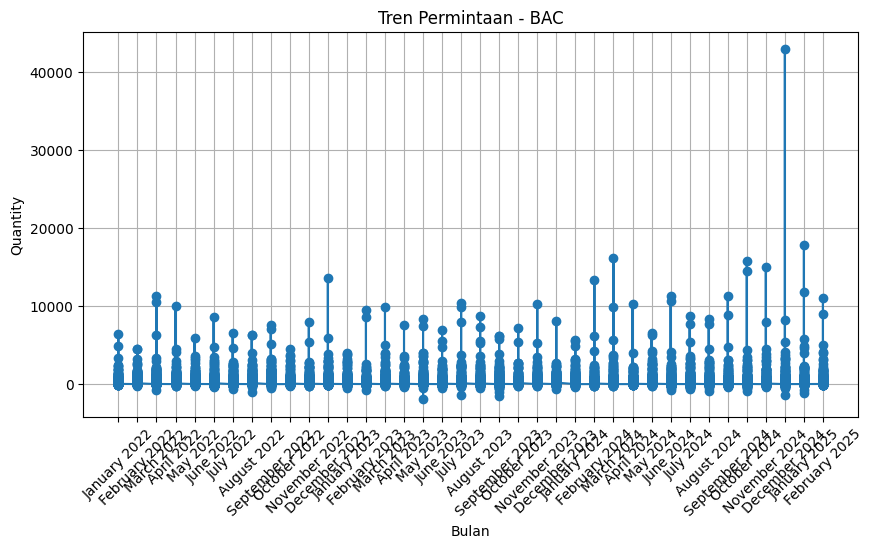

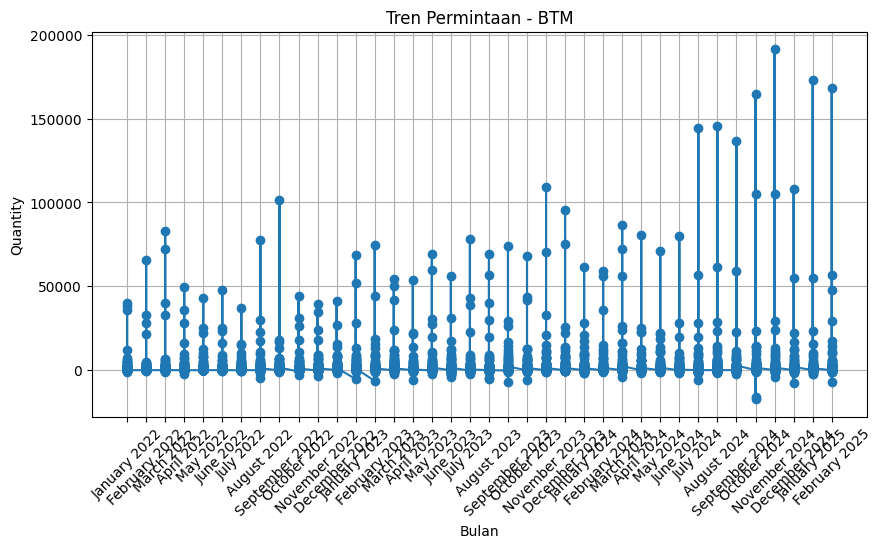

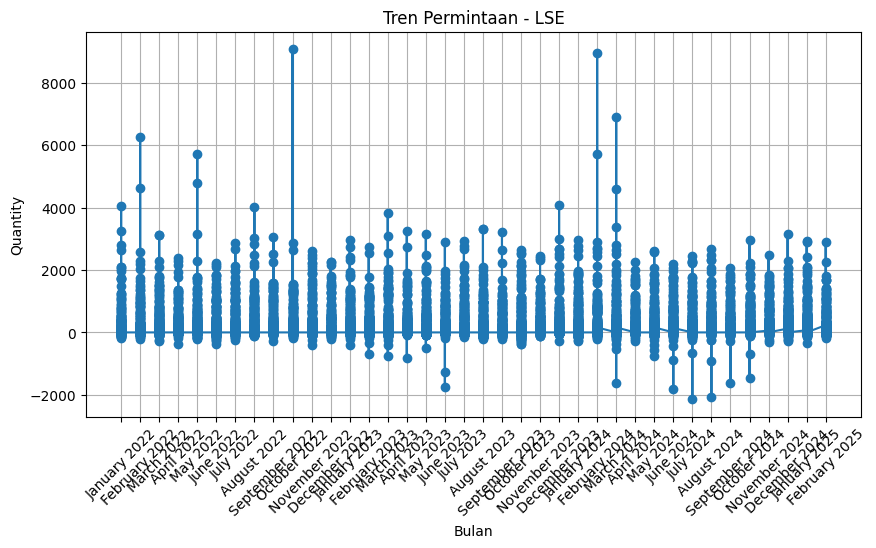

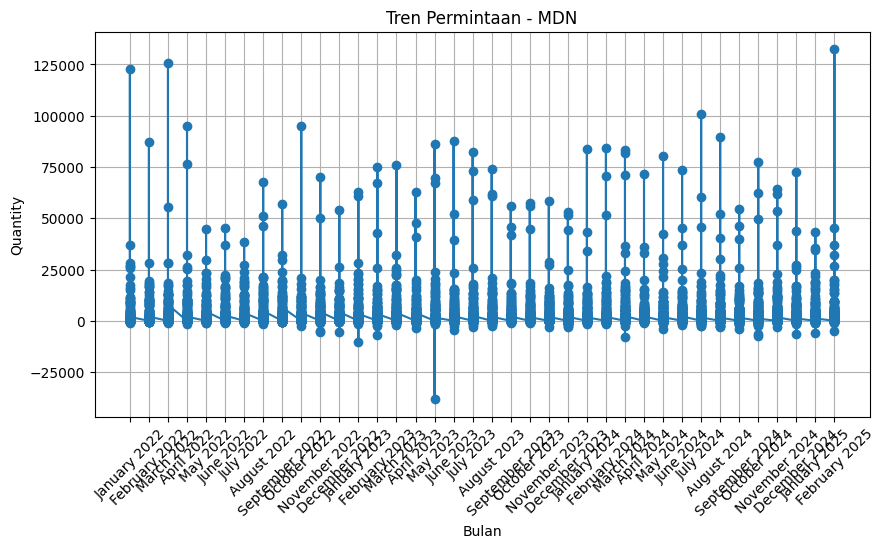

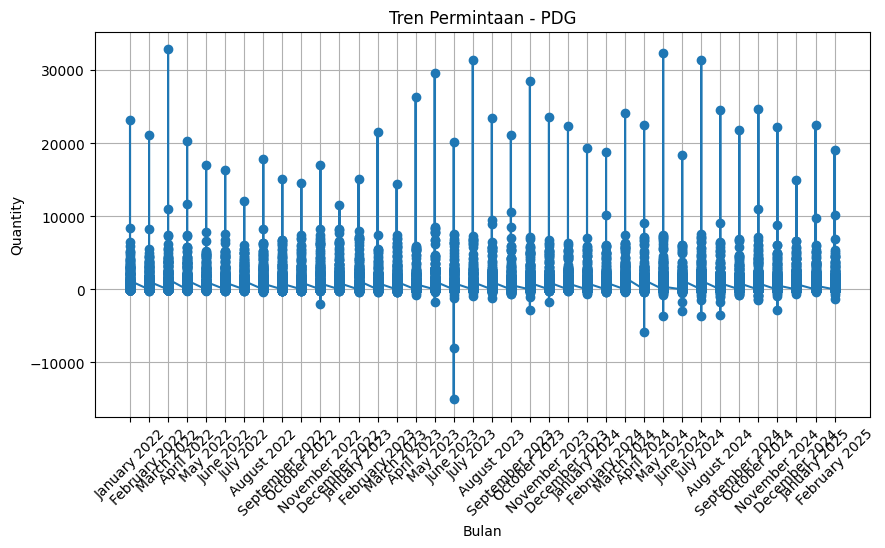

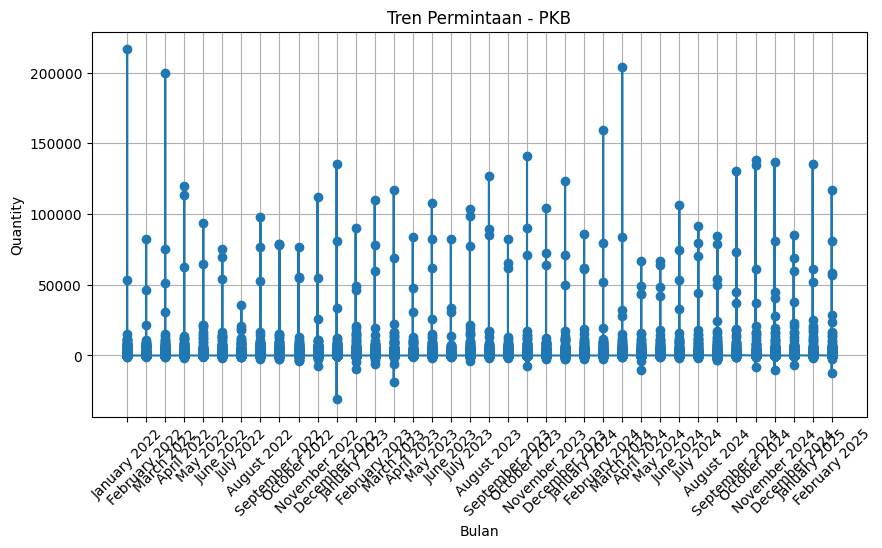

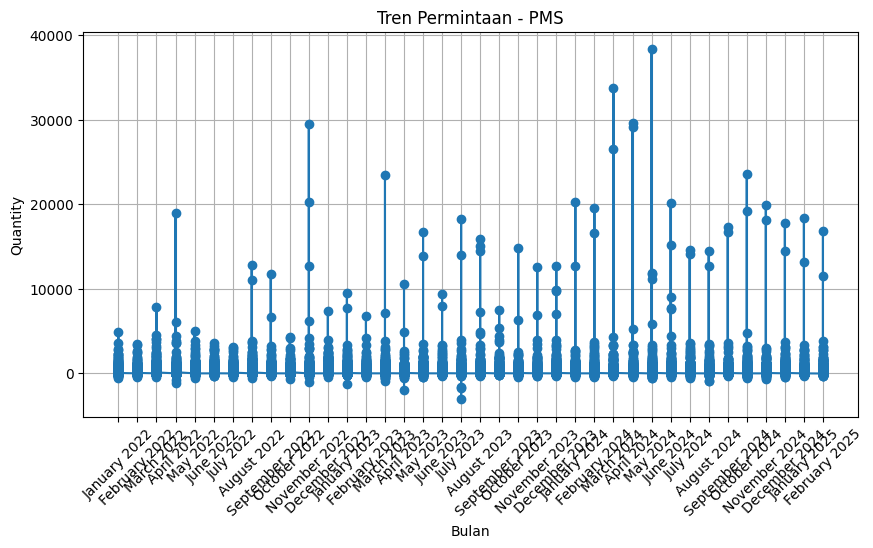

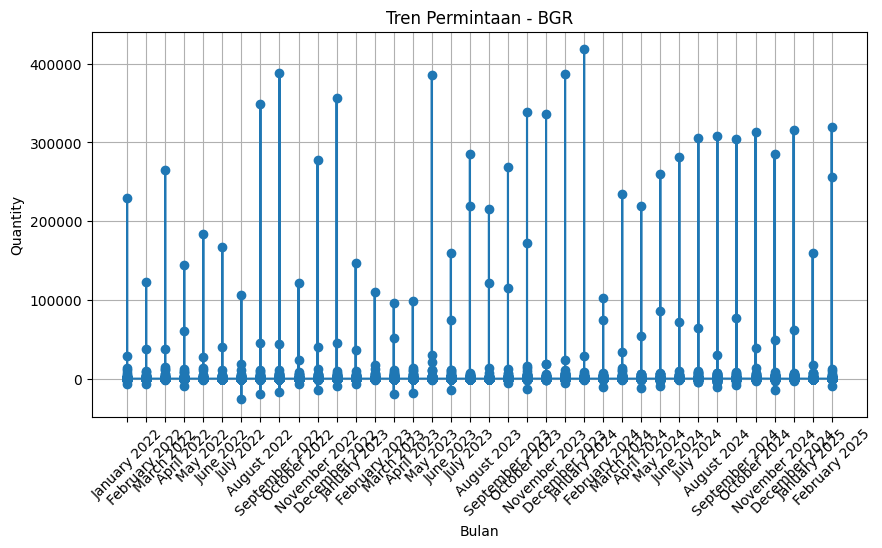

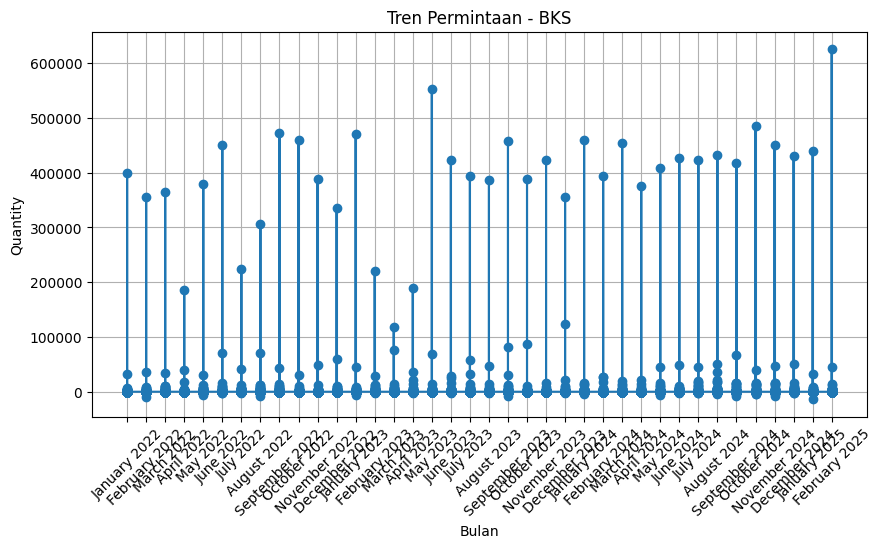

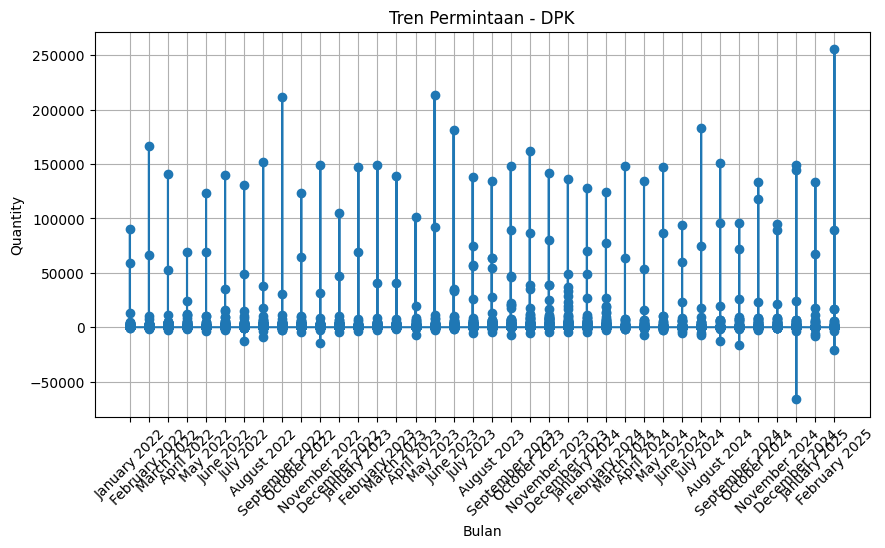

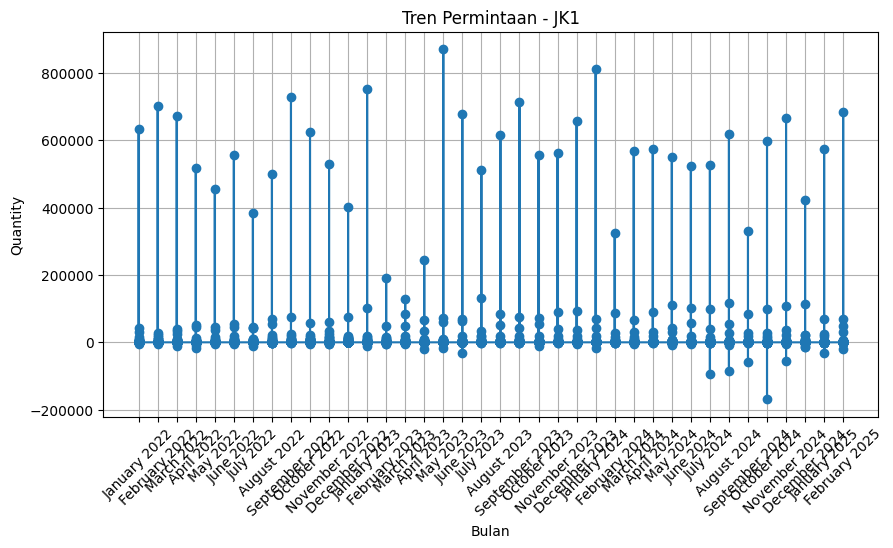

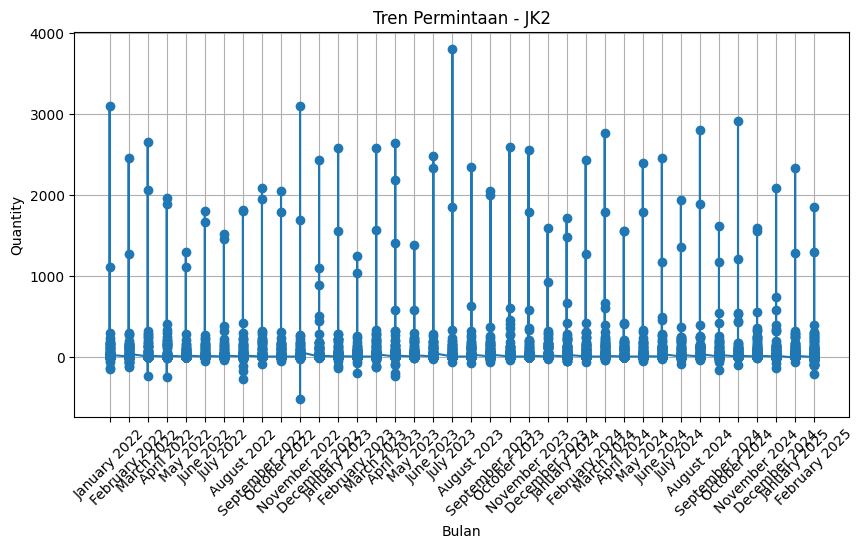

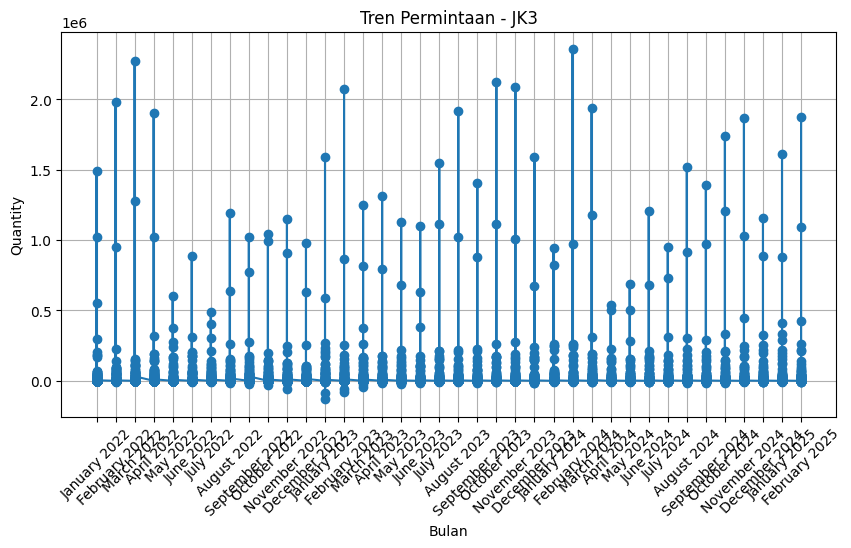

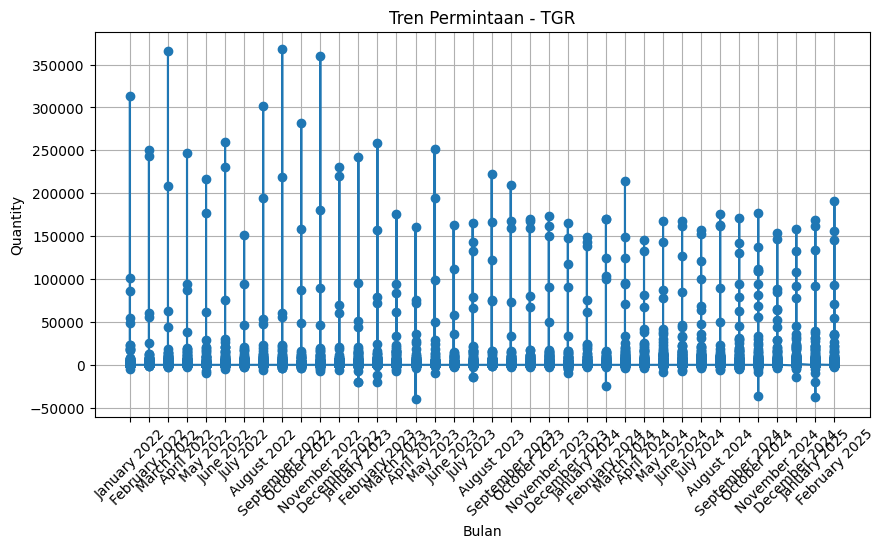

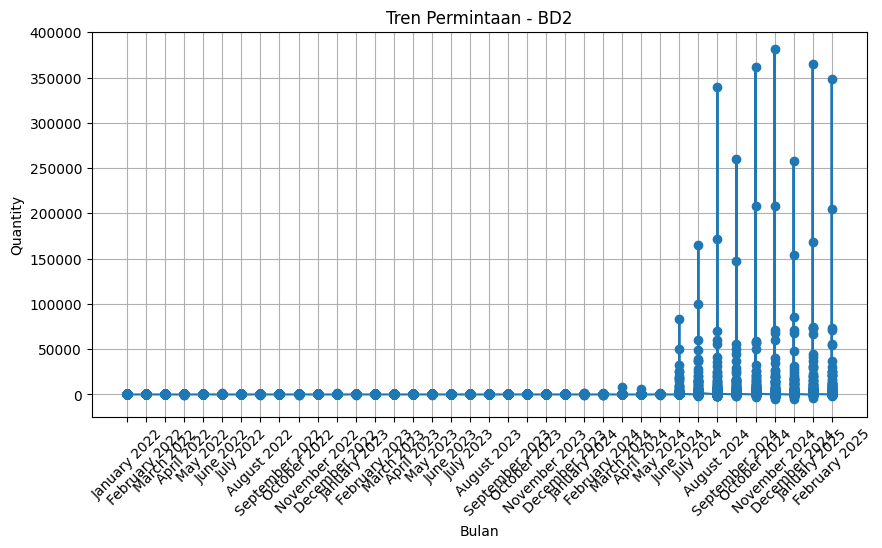

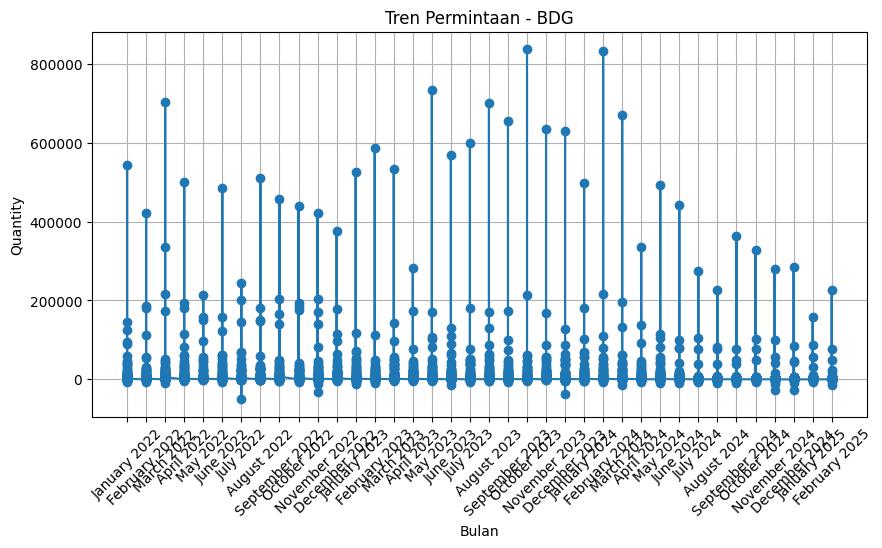

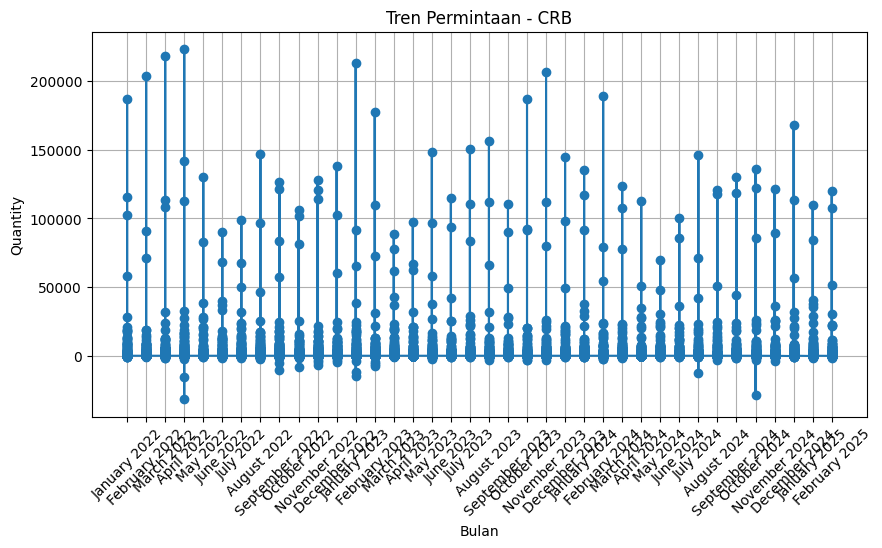

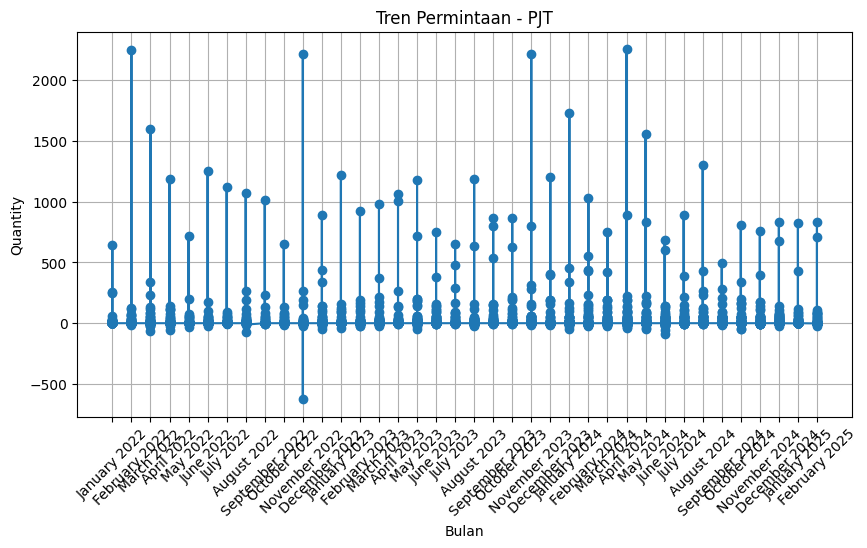

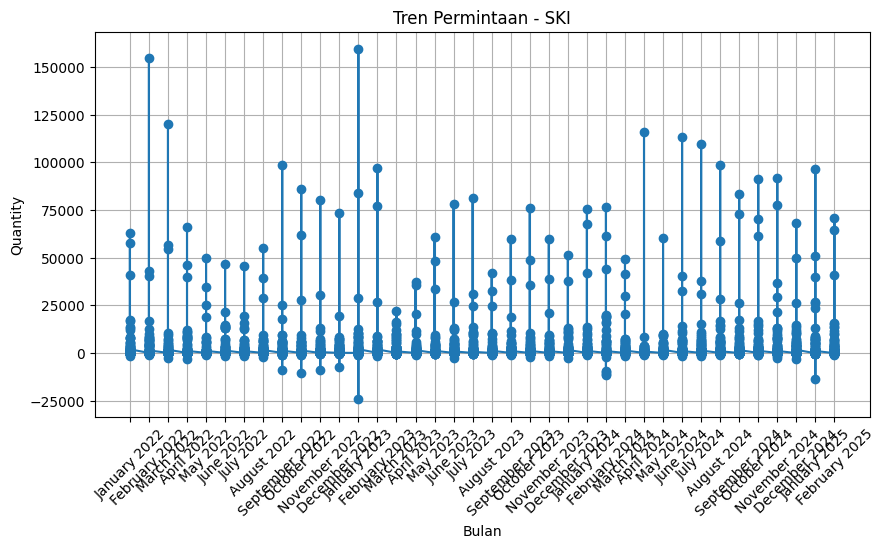

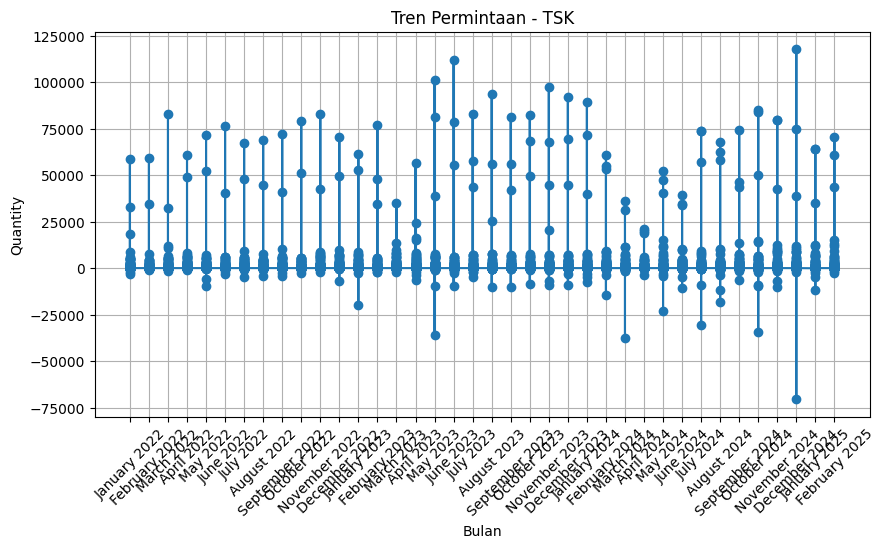

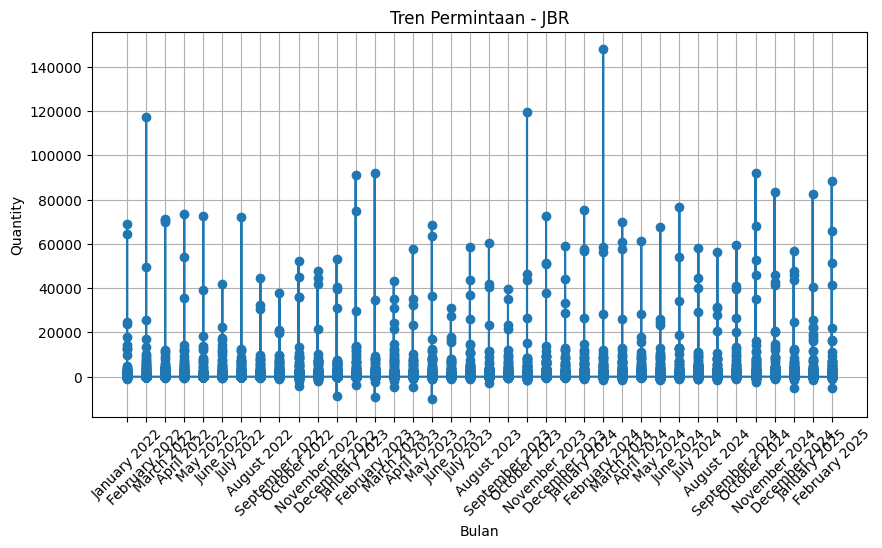

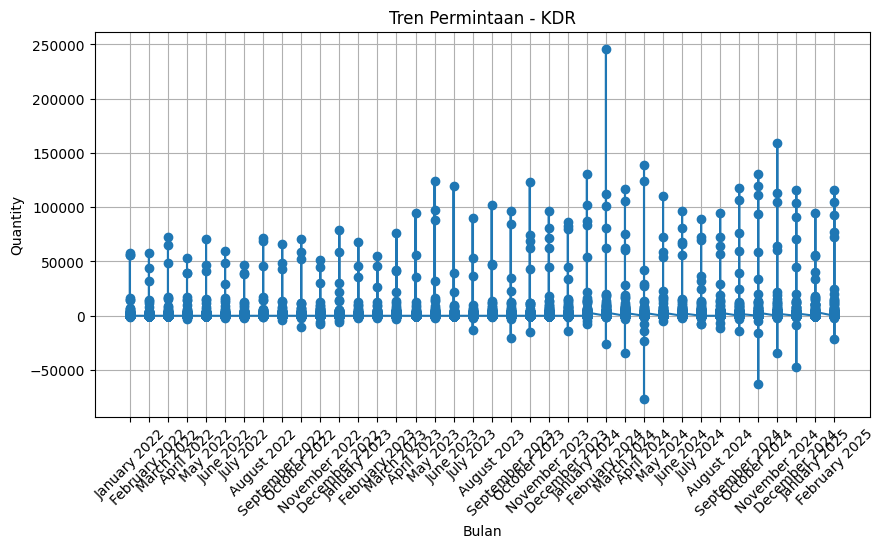

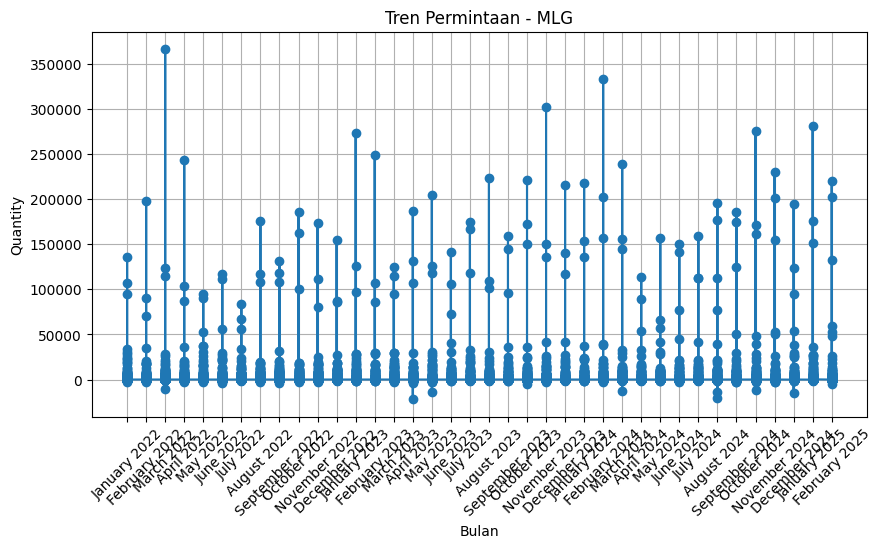

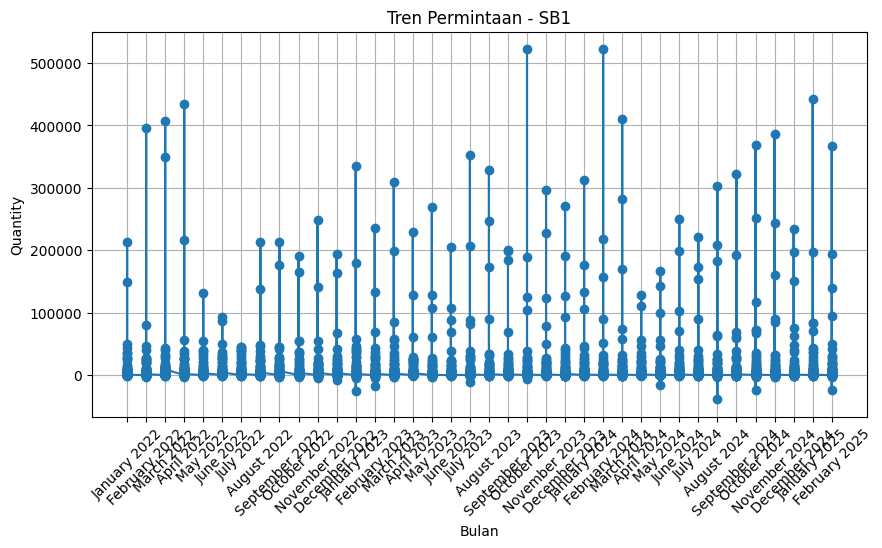

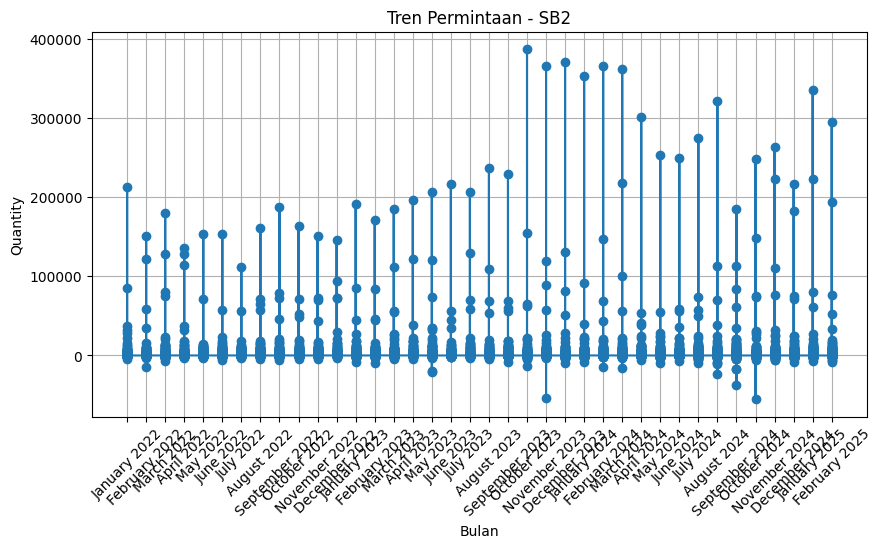

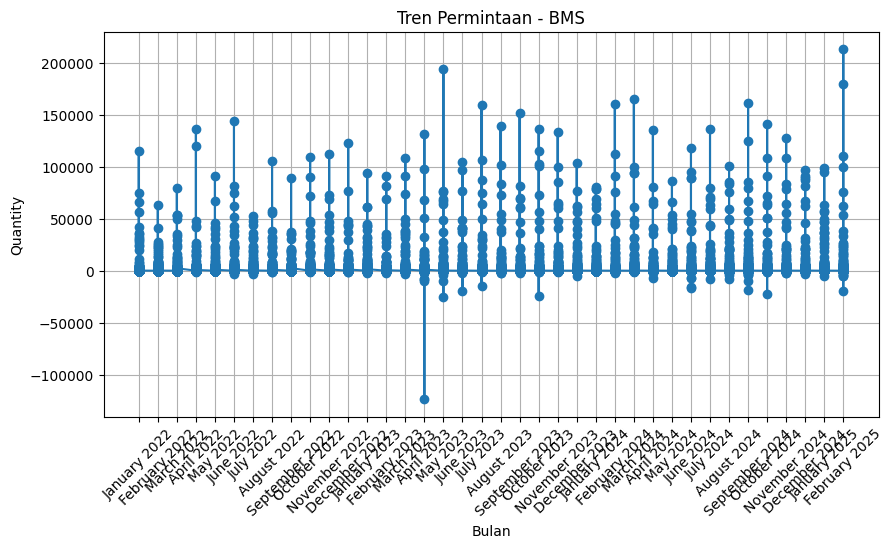

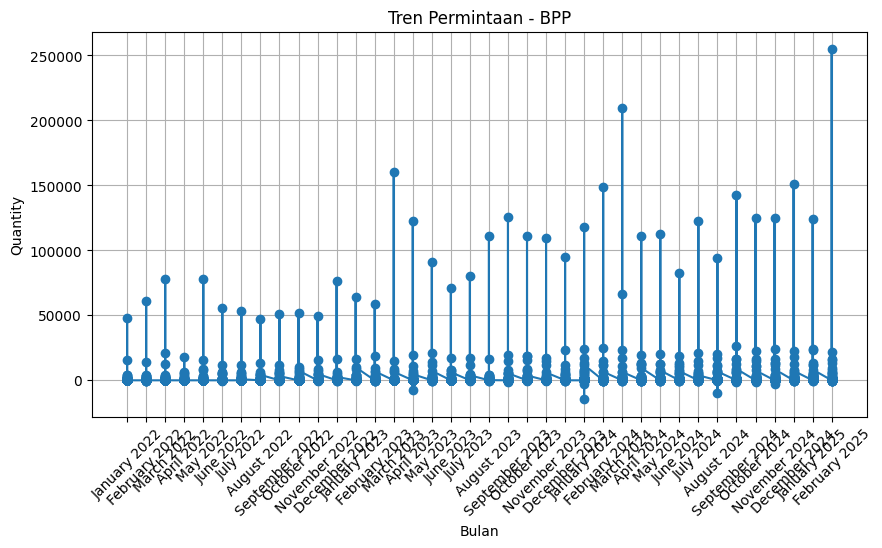

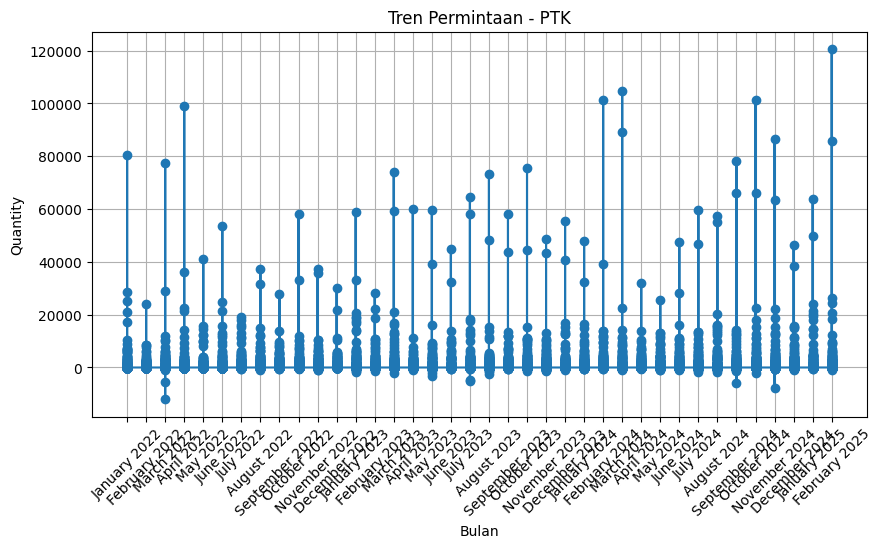

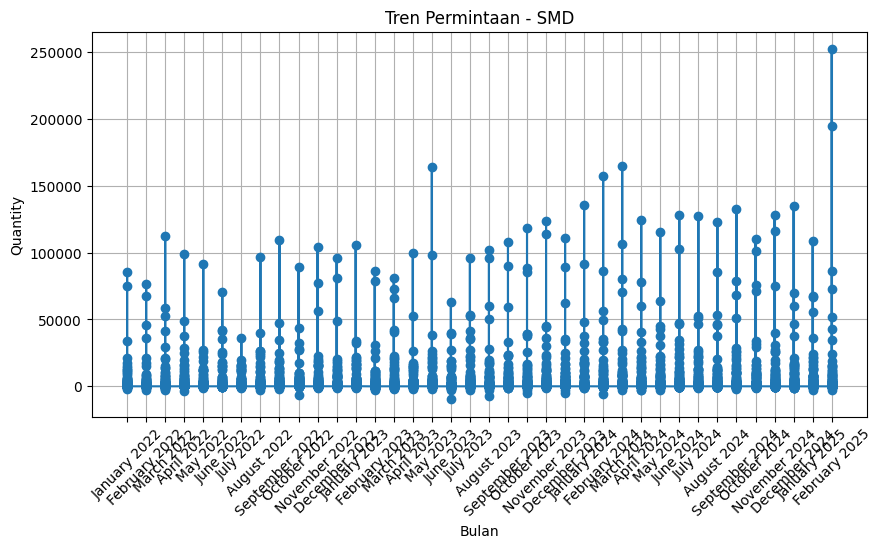

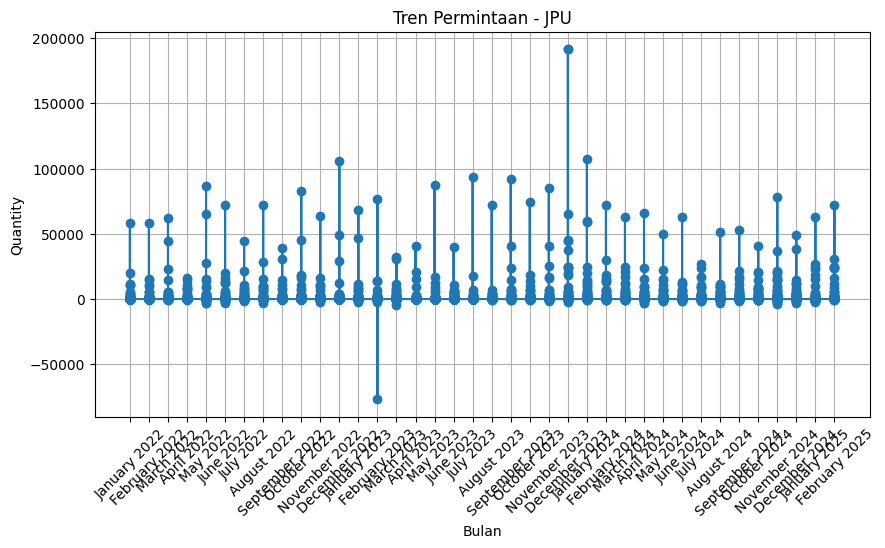

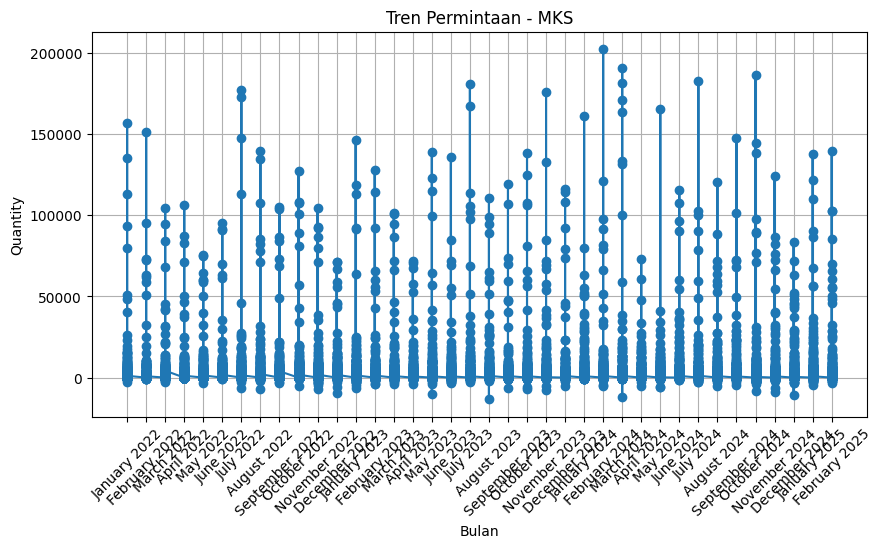

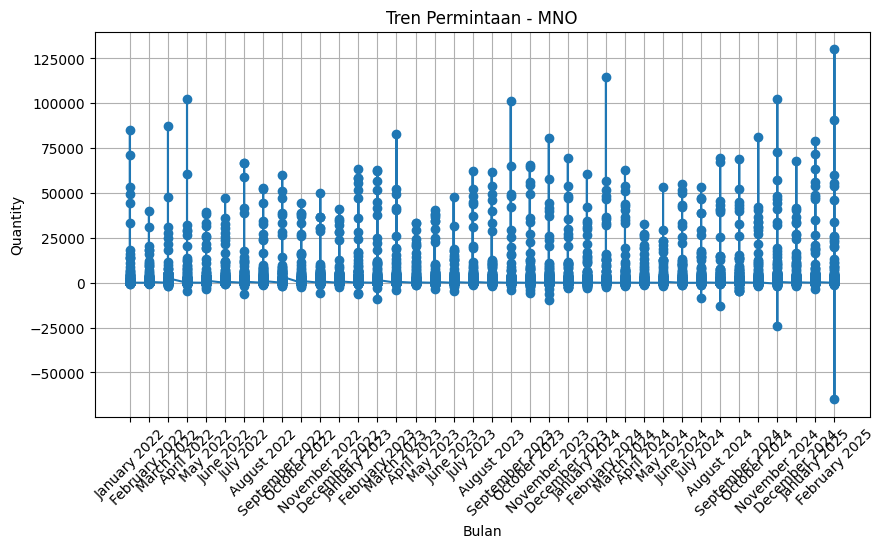

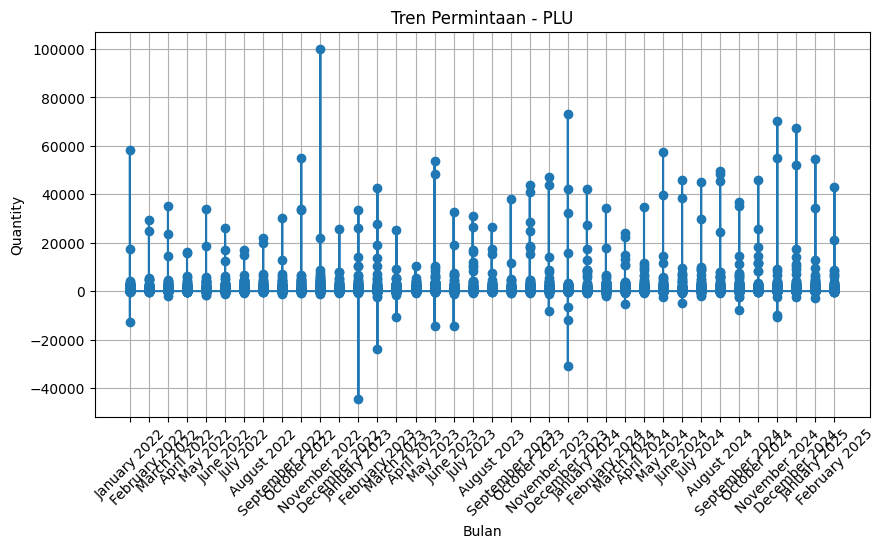

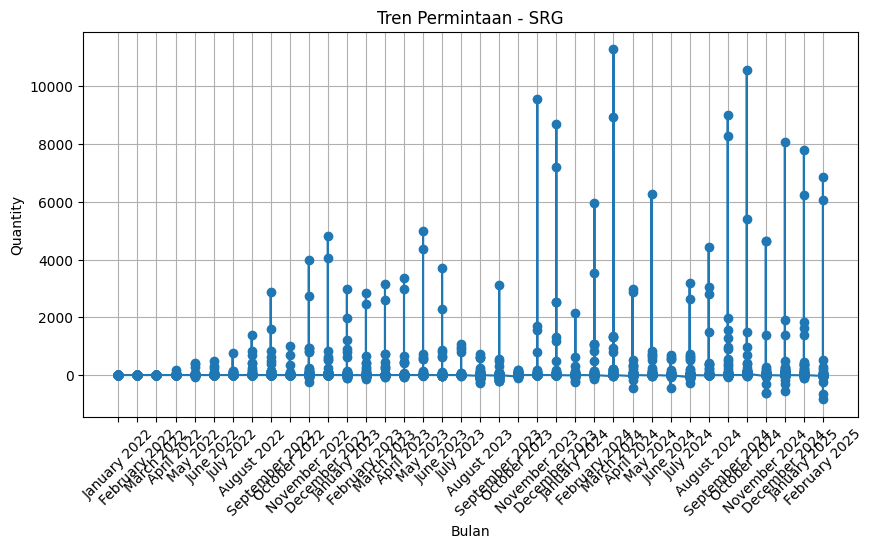

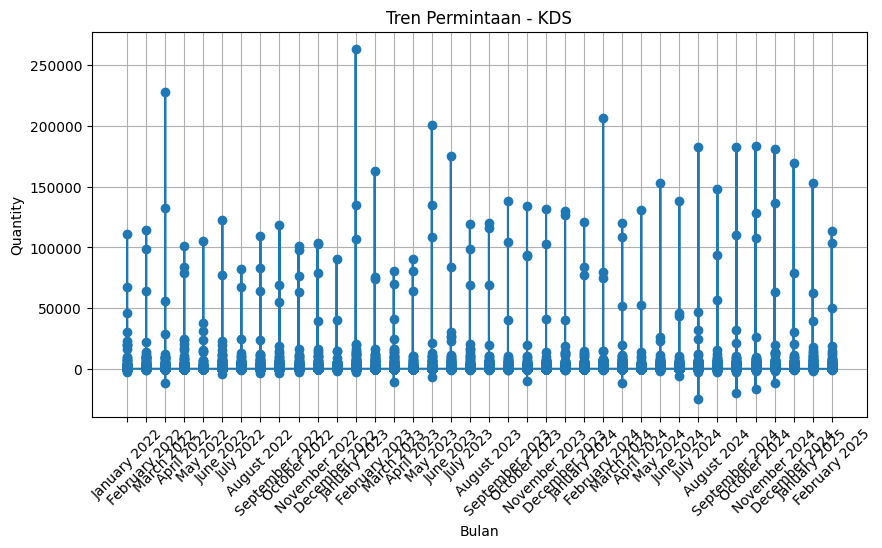

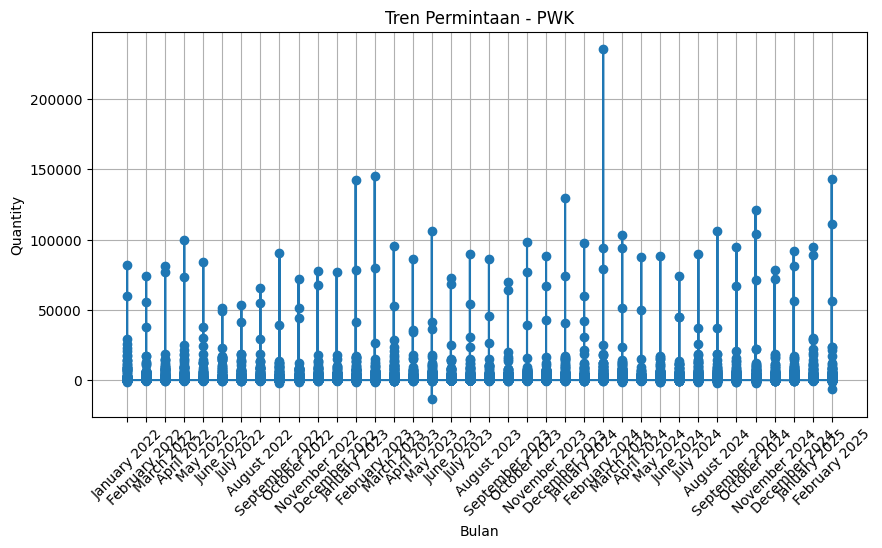

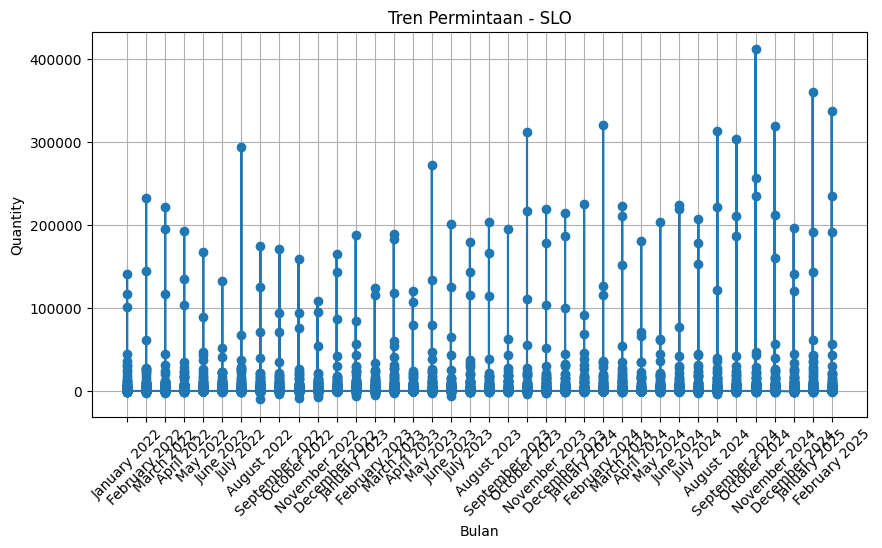

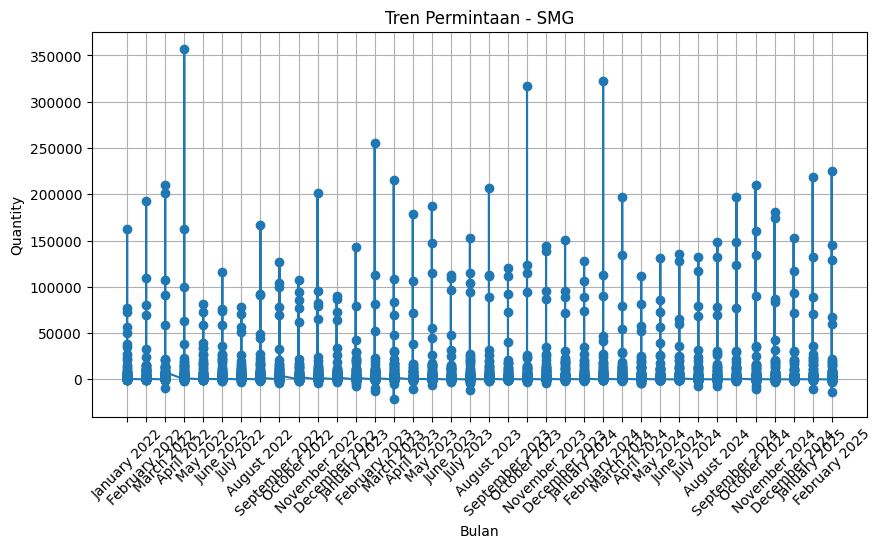

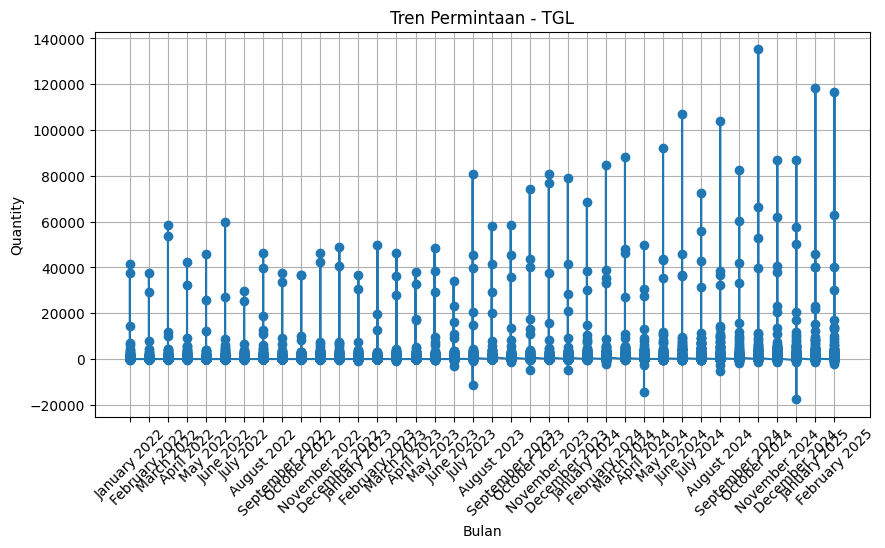

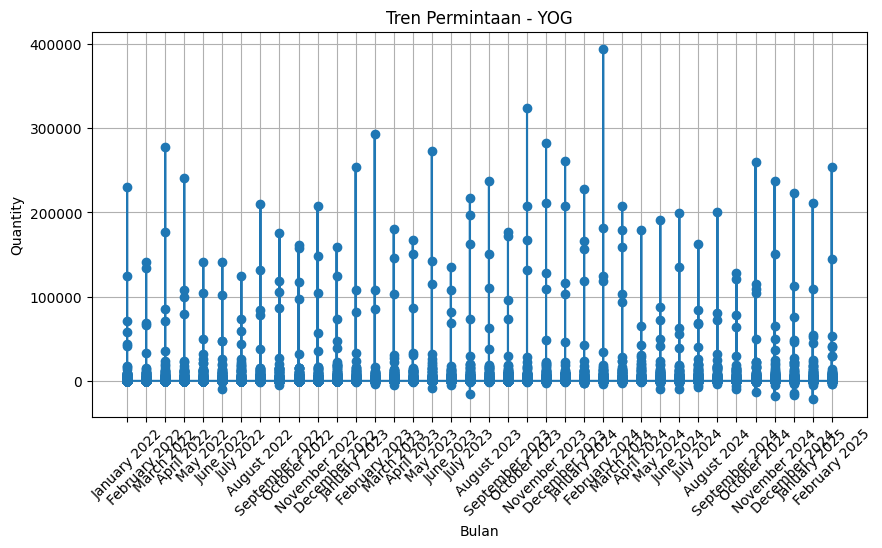

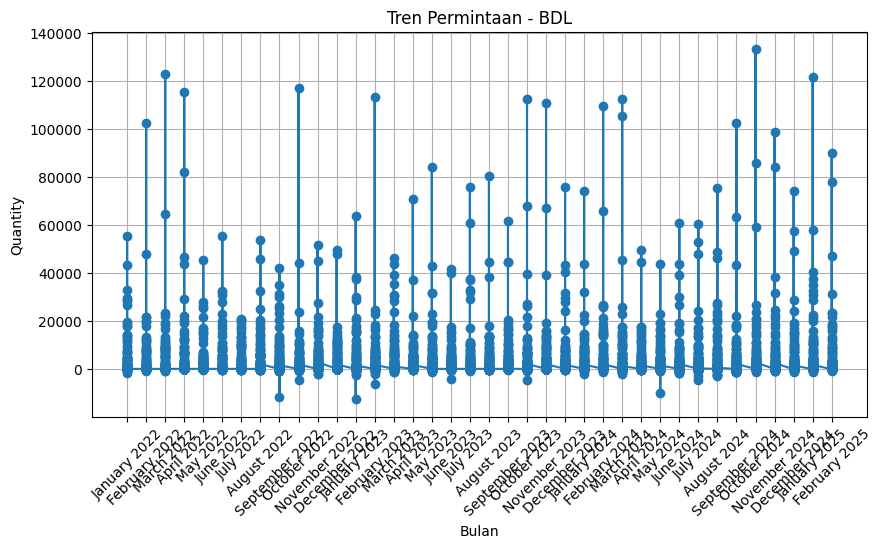

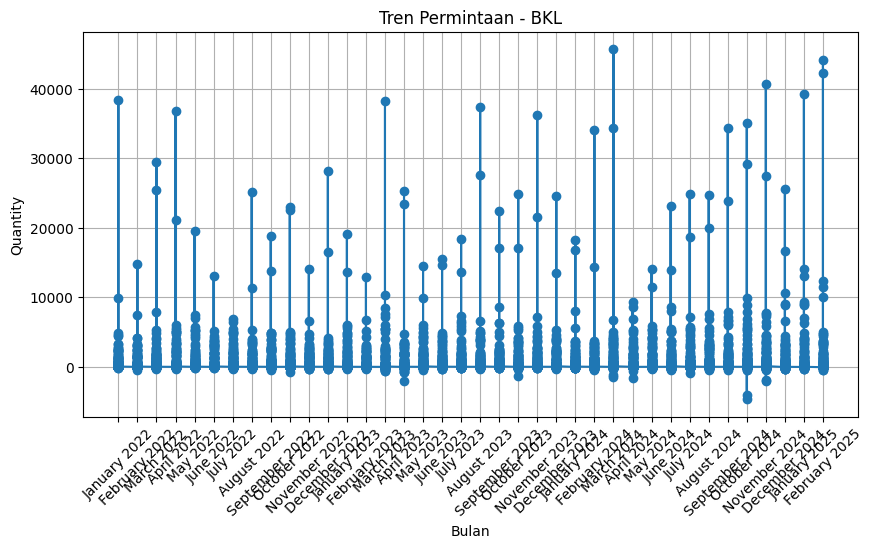

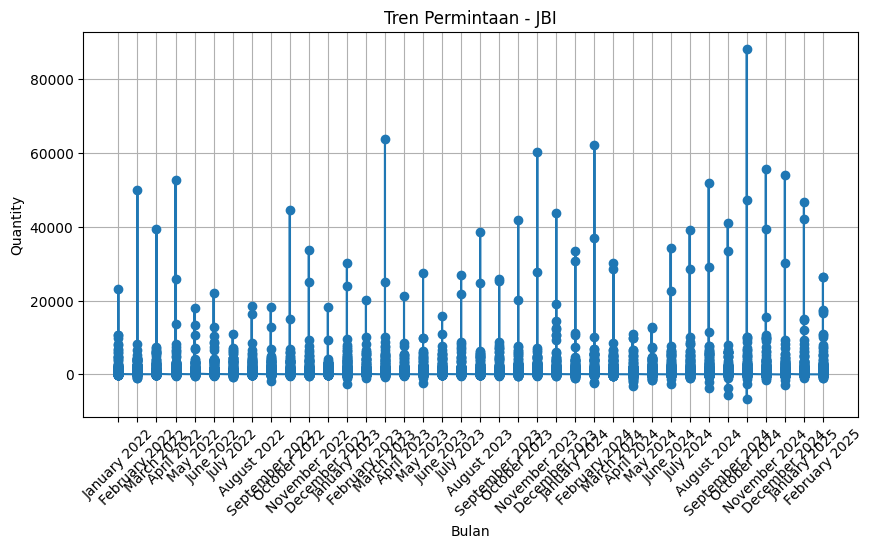

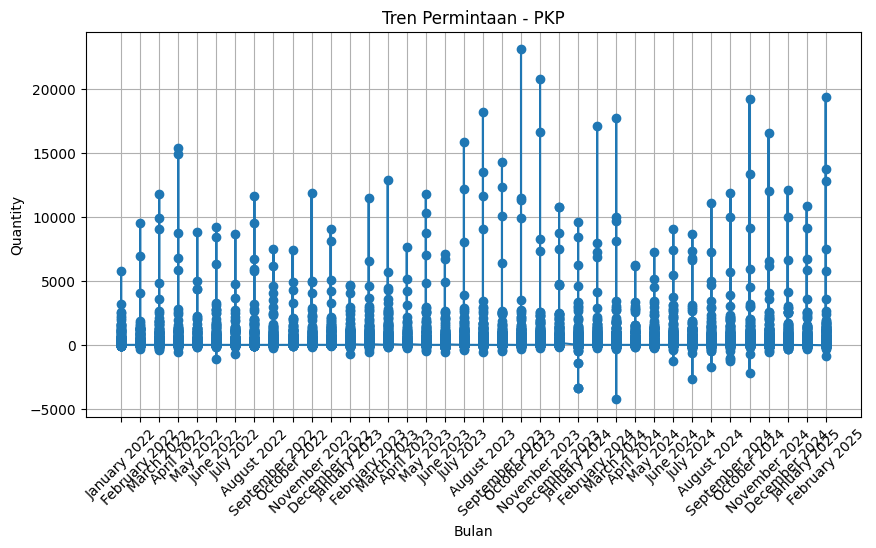

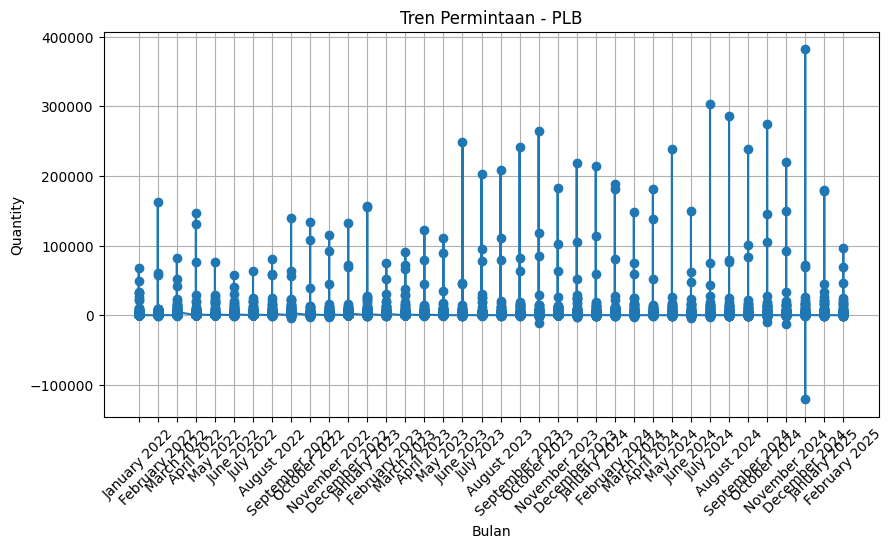

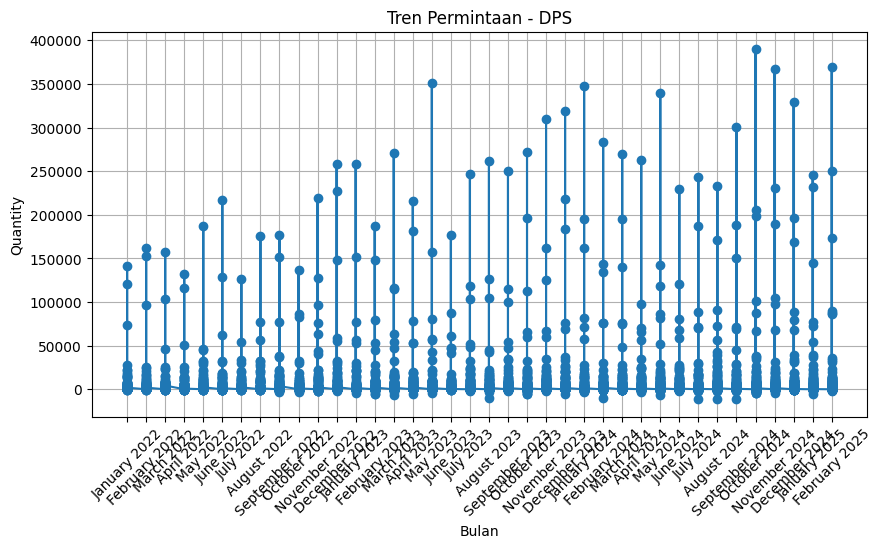

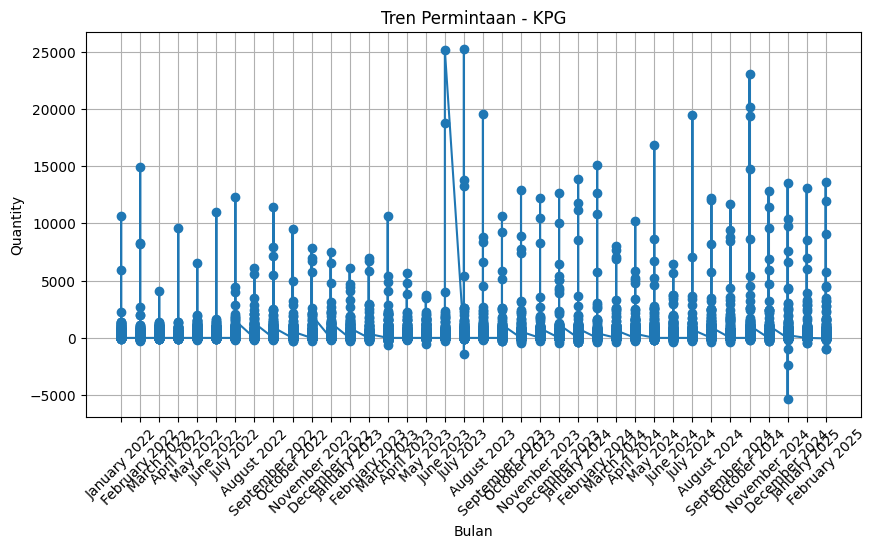

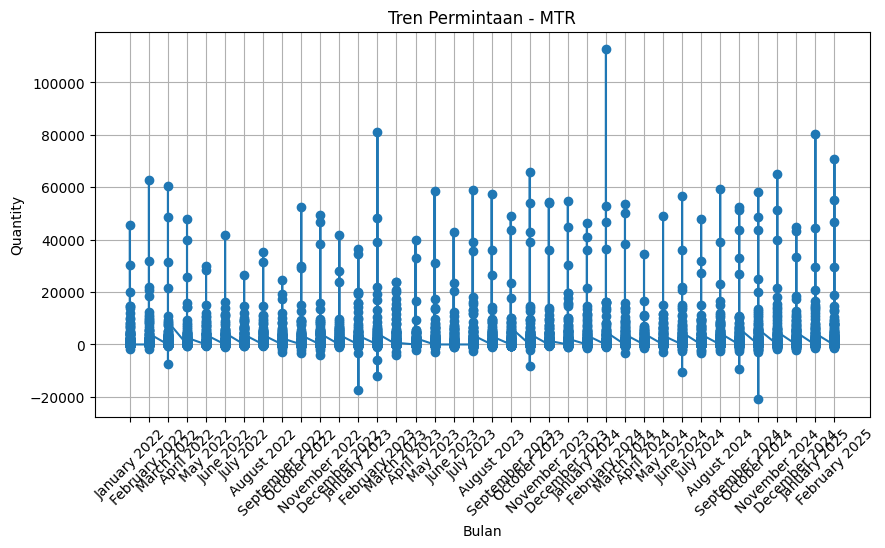

In [85]:
import matplotlib.pyplot as plt

for branch in df["Nama_Branch_EPM"].unique():
    branch_data = df[df["Nama_Branch_EPM"] == branch]

    plt.figure(figsize=(10, 5))
    plt.plot(branch_data["Bulan"], branch_data["qty"], marker='o', linestyle='-')
    plt.title(f"Tren Permintaan - {branch}")
    plt.xlabel("Bulan")
    plt.ylabel("Quantity")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()


Dari hasil visualisasi data Koefisien Variasi pada setiap cabang disimpulkan untuk Cabang JK1 menghasilkan nilai yg paling fluktuatif sebesar 19,28. Hal ini bisa di sebabkan adanya perubahan perilaku konsumen.

In [86]:
# Assuming 'df_long' (or the original DataFrame) contains all necessary columns
df_selected = df_long[['KODE_SUBDIST', 'BRANCH_SUBD', 'Nama_Branch_EPM', 'RSPH', 'Type_Sub',
                   'Line of Business', 'ProductID', 'Umbrand', 'Brand', 'DocumentID', 'Price',
                   'qty', 'Bulan']]  # Ensure all necessary columns are selected including 'Bulan' and 'qty'


# Group by all columns except 'Price', 'qty', but INCLUDE 'Bulan' and aggregate
# Using a list of column names for grouping instead of .drop
grouping_columns = ['KODE_SUBDIST', 'BRANCH_SUBD', 'Nama_Branch_EPM', 'RSPH', 'Type_Sub',
                   'Line of Business', 'ProductID', 'Umbrand', 'Brand', 'DocumentID', 'Bulan']
df_grouped = df_selected.groupby(grouping_columns, as_index=False).agg({'qty': 'sum', 'Price': 'first'})

print(df_grouped.head())  # Check the output to see if it's as expected

   KODE_SUBDIST BRANCH_SUBD Nama_Branch_EPM           RSPH   Type_Sub  \
0         10204         SRB             MDN  RM I SumBagUt  Subdist C   
1         10204         SRB             MDN  RM I SumBagUt  Subdist C   
2         10204         SRB             MDN  RM I SumBagUt  Subdist C   
3         10204         SRB             MDN  RM I SumBagUt  Subdist C   
4         10204         SRB             MDN  RM I SumBagUt  Subdist C   

  Line of Business ProductID   Umbrand Brand DocumentID        Bulan  qty  \
0             KN 1     PCL01  PRENAGEN  LOVA     FAKTUR   April 2022  190   
1             KN 1     PCL01  PRENAGEN  LOVA     FAKTUR   April 2023   32   
2             KN 1     PCL01  PRENAGEN  LOVA     FAKTUR   April 2024    2   
3             KN 1     PCL01  PRENAGEN  LOVA     FAKTUR  August 2022  360   
4             KN 1     PCL01  PRENAGEN  LOVA     FAKTUR  August 2023    0   

   Price  
0  7.346  
1  7.346  
2  7.346  
3  7.346  
4  7.346  


In [87]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1417286 entries, 0 to 1417285
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   KODE_SUBDIST      1417286 non-null  int64  
 1   BRANCH_SUBD       1417286 non-null  object 
 2   Nama_Branch_EPM   1417286 non-null  object 
 3   RSPH              1417286 non-null  object 
 4   Type_Sub          1417286 non-null  object 
 5   Line of Business  1417286 non-null  object 
 6   ProductID         1417286 non-null  object 
 7   Umbrand           1417286 non-null  object 
 8   Brand             1417286 non-null  object 
 9   DocumentID        1417286 non-null  object 
 10  Bulan             1417286 non-null  object 
 11  qty               1417286 non-null  int64  
 12  Price             1417286 non-null  float64
dtypes: float64(1), int64(2), object(10)
memory usage: 140.6+ MB


In [88]:
# Membuat subset DataFrame dengan kolom yang diperlukan
df_filtered = df_grouped[['Nama_Branch_EPM', 'Umbrand', 'Bulan', 'DocumentID', 'qty']]

# Filter hanya baris dengan "FAKTUR" dalam DocumentID
df_faktur = df_filtered[df_filtered['DocumentID'].str.contains('FAKTUR', na=False)]

# Menampilkan hasil
print(df_faktur.head())

  Nama_Branch_EPM   Umbrand        Bulan DocumentID  qty
0             MDN  PRENAGEN   April 2022     FAKTUR  190
1             MDN  PRENAGEN   April 2023     FAKTUR   32
2             MDN  PRENAGEN   April 2024     FAKTUR    2
3             MDN  PRENAGEN  August 2022     FAKTUR  360
4             MDN  PRENAGEN  August 2023     FAKTUR    0


In [89]:
print(df_faktur['Bulan'].unique())

['April 2022' 'April 2023' 'April 2024' 'August 2022' 'August 2023'
 'August 2024' 'December 2022' 'December 2023' 'December 2024'
 'February 2022' 'February 2023' 'February 2024' 'February 2025'
 'January 2022' 'January 2023' 'January 2024' 'January 2025' 'July 2022'
 'July 2023' 'July 2024' 'June 2022' 'June 2023' 'June 2024' 'March 2022'
 'March 2023' 'March 2024' 'May 2022' 'May 2023' 'May 2024'
 'November 2022' 'November 2023' 'November 2024' 'October 2022'
 'October 2023' 'October 2024' 'September 2022' 'September 2023'
 'September 2024']


In [90]:
df_faktur.info()

<class 'pandas.core.frame.DataFrame'>
Index: 759088 entries, 0 to 1417247
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Nama_Branch_EPM  759088 non-null  object
 1   Umbrand          759088 non-null  object
 2   Bulan            759088 non-null  object
 3   DocumentID       759088 non-null  object
 4   qty              759088 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 34.7+ MB


In [91]:
df_faktur['qty'].unique()

array([  190,    32,     2, ..., 17482, 17516, 21004])

In [92]:
df_faktur['qty'] = np.log(df_faktur['qty'] + 1)

<ipython-input-92-206a5da4c837>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faktur['qty'] = np.log(df_faktur['qty'] + 1)


In [93]:
df_faktur['DocumentID'].unique()

array(['FAKTUR'], dtype=object)

In [94]:
print(df_faktur.describe())

                 qty
count  759088.000000
mean        3.587559
std         3.040549
min         0.000000
25%         0.000000
50%         4.204693
75%         5.973810
max        14.672907


Tidak ada data yg tidak masuk akal

In [95]:
jumlah_nol = (df_faktur['qty'] == 0).sum()
print(f'Jumlah nilai 0 dalam qty: {jumlah_nol}')

Jumlah nilai 0 dalam qty: 269309


In [96]:
df_faktur['qty'] = df_faktur['qty'].replace(0, np.nan).interpolate(method='linear')

<ipython-input-96-0bce98e9da8d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faktur['qty'] = df_faktur['qty'].replace(0, np.nan).interpolate(method='linear')


In [97]:
print(df_faktur.isnull().sum())  # Cek apakah masih ada NaN setelah interpolasi

Nama_Branch_EPM    0
Umbrand            0
Bulan              0
DocumentID         0
qty                0
dtype: int64


In [98]:
print(df_faktur['qty'].describe())  # Lihat distribusi data setelah dibersihkan


count    759088.000000
mean          5.219383
std           1.842825
min           1.098612
25%           3.901718
50%           5.168852
75%           6.381816
max          14.672907
Name: qty, dtype: float64


TRAIN AND TEST DATA

In [99]:
train_size = int(len(df_faktur) * 0.8)  # 80% untuk train
train = df_faktur.iloc[:train_size]  # Data training
test = df_faktur.iloc[train_size:]   # Data testing


1. Moving Average

In [100]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming 'df_faktur' is your DataFrame with 'Bulan' and 'qty' columns

# 1. Create the Moving Average Model
def moving_average(data, window_size):
    """Calculates the moving average of a series."""
    return data['qty'].rolling(window=window_size, center=True).mean()

# Choose a window size (e.g., 3 months)
window_size = 3

# 2. Split data into train and test sets *BEFORE* calculating the moving average
train_size = int(len(df_faktur) * 0.8)
train = df_faktur.iloc[:train_size]
test = df_faktur.iloc[train_size:]

# Calculate moving average for train and test separately
train['MA'] = moving_average(train, window_size)
test['MA'] = moving_average(test, window_size)

# 3. Evaluate the model using MSD and MAD
# Calculate MSD and MAD for the test set, but handle NaNs
# Drop rows with NaN values in either 'qty' or 'MA' columns in the test set
test_cleaned = test.dropna(subset=['qty', 'MA'])

MSD = mean_squared_error(test_cleaned['qty'], test_cleaned['MA'])
MAD = mean_absolute_error(test_cleaned['qty'], test_cleaned['MA'])

# 4. Create a table for visualization
# Create a DataFrame with actual, predicted, and error columns
results_df = pd.DataFrame({'Actual': test_cleaned['qty'], 'Predicted': test_cleaned['MA']})
results_df['Error'] = results_df['Actual'] - results_df['Predicted']

# Display the table with MSD and MAD
print("Moving Average Model Results:")
print(results_df)
print(f"\nMean Squared Deviation (MSD): {MSD}")
print(f"Mean Absolute Deviation (MAD): {MAD}")

Moving Average Model Results:
           Actual  Predicted         Error
1133267  5.899897   5.941446 -4.154839e-02
1133268  5.867304   5.867304  0.000000e+00
1133269  5.834711   5.834711  0.000000e+00
1133270  5.802118   5.681094  1.210243e-01
1133271  5.406452   5.406452  0.000000e+00
...           ...        ...           ...
1417242  8.760935   8.760935  1.065814e-14
1417243  8.688263   8.688263  1.065814e-14
1417244  8.615590   8.698418 -8.282824e-02
1417245  8.791401   8.791401  1.065814e-14
1417246  8.967213   8.967213  1.065814e-14

[151816 rows x 3 columns]

Mean Squared Deviation (MSD): 0.15110753686390108
Mean Absolute Deviation (MAD): 0.2054668214260878


<ipython-input-100-ef2c43b7d93b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['MA'] = moving_average(train, window_size)
<ipython-input-100-ef2c43b7d93b>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['MA'] = moving_average(test, window_size)


2. Simple Exponential Smoothing

In [101]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# ... (previous code for models and calculations) ...

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Model': ['Moving Average', 'Simple Exponential Smoothing'],
    'MSD': [MSD_MA, MSD_SES],
    'MAD': [MAD_MA, MAD_SES],
    'MAPE': [f"{MAPE_MA:.2f}%", f"{MAPE_SES:.2f}%"]  # Format MAPE as percentage
})

# Display the table
print(results_df.to_string(index=False))  # index=False removes the index column

                       Model      MSD      MAD   MAPE
              Moving Average 0.151108 0.205467  4.92%
Simple Exponential Smoothing 4.507743 1.700391 50.85%


3. Double Exponential Smoothing

In [102]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Sample data representing monthly demand (replace with your actual data)
data = {'Month': pd.to_datetime(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01']),
        'Demand': [100, 110, 120, 115, 130, 125]}
df = pd.DataFrame(data)
df.set_index('Month', inplace=True)

# Fit Double Exponential Smoothing model
model = ExponentialSmoothing(df['Demand'], trend='add', seasonal=None).fit()

# Make predictions
df['Forecast'] = model.fittedvalues

# Calculate evaluation metrics
actual = df['Demand']
predicted = df['Forecast']

MSD = mean_squared_error(actual, predicted)
MAD = mean_absolute_error(actual, predicted)
MAPE = np.mean(np.abs((actual - predicted) / actual)) * 100

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Metric': ['MSD', 'MAD', 'MAPE'],
    'Value': [MSD, MAD, MAPE]
})

# Display the table
print(results_df.to_string(index=False))

Metric     Value
   MSD 20.079365
   MAD  4.190476
  MAPE  3.551539


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


4. ARIMA

In [103]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

# Sample data representing monthly demand (replace with your actual data)
data = {'Month': pd.to_datetime(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01']),
        'Demand': [100, 110, 120, 115, 130, 125]}
df = pd.DataFrame(data)
df.set_index('Month', inplace=True)

# Fit ARIMA model
# (p, d, q) are the model orders - you might need to experiment to find the best values
model = ARIMA(df['Demand'], order=(5, 1, 0)).fit()

# Make predictions
df['Forecast'] = model.predict()

# Calculate evaluation metrics
actual = df['Demand']
predicted = df['Forecast']

MSD = mean_squared_error(actual, predicted)
MAD = mean_absolute_error(actual, predicted)
MAPE = np.mean(np.abs((actual - predicted) / actual)) * 100

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Metric': ['MSD', 'MAD', 'MAPE'],
    'Value': [MSD, MAD, MAPE]
})

# Display the table
print(results_df.to_string(index=False))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Metric       Value
   MSD 1720.191809
   MAD   22.153674
  MAPE   21.406284


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KESIMPULAN

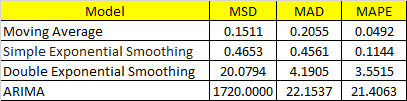

Dari data diatas dapat disimpulkan bahwa moving average menjadi model yang memiliki akurasi yang tinggi jika dilihat dari nilai MSD, MAD, MAPE yang rendah.